## Predicting Restaurant Health Inspection Scores Using Yelp Reviews

<h2 style="color: lightskyblue;">I. Introduction</h2>

The objective of our project is to apply data science techniques from our Intro to Data Science Course in order to build out models that can accurately predict health inspection outcomes for restaurants in a given area. We aim to combine Natural Language Processing of review text for sentiment analysis with structured meta data to construct these predictive models. <br><br>
In order to best explore our data, we will follow the *Knowledge Discovery from Data* approach. Namely, we seek to:
+ Clean the selected datasets to remove noise
+ Integrate and join data from  two sources (Yelp Academic Dataset and Select City Health Scores)
+ Select the relevant data from our constructed dataset for analysis
+ Transform our data into a usable form for mining
+ Mine our data to find interesting patterns
+ Evaluate our patterns based on interestingness to construct our models
+ Present our mined knowledge and models to positively impact the consumers ability to recognize safe restaurants

In [1]:
# Code Snippet 1 - Importing libraries to be used throughout notebook
import json
import pandas as pd
import matplotlib.pyplot as plt

<h2 style="color: lightskyblue;">II. Cleaning Selected Datasets</h2>

To clean our data sets and prepare them for joining so that we may build out our classification models, we pursue 2 tasks:
1. *Cleaning our Yelp data*
2. *Cleaning our City health inspection data*

<h3 style="color: orange;">Task 1: Cleaning Yelp Data</h3>

We begin our data analysis process by working with our Yelp dataset in JSON format in order to clean the data and bring it down to a workable size. Our selected city for analysis is Tampa as both the Yelp and Health Department data are well populated. <br><br>
**NOTE** - Due to the large size of the datasets being operated upon, we have not included them in our repository. Please visit https://www.yelp.com/dataset if you wish to run this analysis locally and ensure that the following files are placed in the raw_datasets directory after cloning.
+ *yelp_academic_dataset_business.json*
+ *yelp_academic_dataset_review.json*

In [2]:
# Task 1 Snippet A - Cleaning the Business IDs

target_city = "Tampa"
target_state = "FL"
business_ids = set()
filtered_businesses = []

with open('./raw_datasets/yelp_academic_dataset_business.json', 'r', encoding = 'utf-8') as f:
    for line in f:
        data = json.loads(line)
        if data.get('city') == target_city and data.get('state') == target_state:
            filtered_businesses.append(data)
            business_ids.add(data['business_id'])

# Save filtered businesses
with open('filtered_business.json', 'w', encoding='utf-8') as f:
    for b in filtered_businesses:
        f.write(json.dumps(b) + '\n')

**NOTE** - In your directory, you can now see the result of this script as our *filtered_business.json* file.

In [3]:
# Task 1 Snippet B - Filtering the Reviews
filtered_reviews = []

with open('./raw_datasets/yelp_academic_dataset_review.json', 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        if data['business_id'] in business_ids:
            filtered_reviews.append(data)

with open('filtered_reviews.json', 'w', encoding='utf-8') as f:
    for r in filtered_reviews:
        f.write(json.dumps(r) + '\n')

**NOTE** - In your directory, you can now see the result of this script as our *filtered_reviews.json* file.

In [4]:
# Task 1 Snippet C - Importing reviews and business IDs as a data frame to clean unused columns

def load_json_lines(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return pd.DataFrame([json.loads(line) for line in f])

business_df = load_json_lines('filtered_business.json')
review_df = load_json_lines('filtered_reviews.json')

# Join on business_id
combined_df = review_df.merge(business_df, on='business_id', suffixes=('_review', '_business'))

combined_df[['stars_review', 'text', 'name', 'categories']].head()

,stars_review,text,name,categories
0,5.0,My experience with Shalimar was nothing but wo...,Shalimar Fine Jewelers,"Shopping, Jewelry"
1,4.0,"Very helpful and patient. 20"" 14k gold chain ...",Shalimar Fine Jewelers,"Shopping, Jewelry"
2,5.0,They were all very easy to work with and went ...,Shalimar Fine Jewelers,"Shopping, Jewelry"
3,1.0,They have forever lost my business. Ordered a ...,Shalimar Fine Jewelers,"Shopping, Jewelry"
4,1.0,please dont go here they have bullshit gold th...,Shalimar Fine Jewelers,"Shopping, Jewelry"


In [42]:
# Task 1 Snippet D - Refining the schema of the combined_df
print(combined_df.columns)
combined_df_refined = combined_df[['business_id', 'stars_review', 'text', 'address', 'categories', 'name',]]
combined_df_refined.head()

Index(['business_id', 'cool', 'date', 'funny', 'review_id', 'stars_review',
       'text', 'useful', 'user_id', 'address', 'attributes', 'categories',
       'city', 'hours', 'is_open', 'latitude', 'longitude', 'name',
       'postal_code', 'review_count', 'stars_business', 'state'],
      dtype='object')


,business_id,stars_review,text,address,categories,name
0,uMvVYRgGNXf5boolA9HXTw,5.0,My experience with Shalimar was nothing but wo...,250 Westshore Plz,"Shopping, Jewelry",Shalimar Fine Jewelers
1,uMvVYRgGNXf5boolA9HXTw,4.0,"Very helpful and patient. 20"" 14k gold chain ...",250 Westshore Plz,"Shopping, Jewelry",Shalimar Fine Jewelers
2,uMvVYRgGNXf5boolA9HXTw,5.0,They were all very easy to work with and went ...,250 Westshore Plz,"Shopping, Jewelry",Shalimar Fine Jewelers
3,uMvVYRgGNXf5boolA9HXTw,1.0,They have forever lost my business. Ordered a ...,250 Westshore Plz,"Shopping, Jewelry",Shalimar Fine Jewelers
4,uMvVYRgGNXf5boolA9HXTw,1.0,please dont go here they have bullshit gold th...,250 Westshore Plz,"Shopping, Jewelry",Shalimar Fine Jewelers


From the above, we can see that even in our combined and refined data frame, we are still holding onto data points we do not wish to assess. Nominally, we must only include those categories of business that have food in the category.

In [43]:
# Task 1 Snippet E - Generating final tampa_review_df
tampa_review_df = ( combined_df_refined[combined_df_refined['categories'].str.contains('Food', na=False)] \
                   .drop(columns=['categories']) )
tampa_review_df.head()

,business_id,stars_review,text,address,name
280,cg4JFJcCxRTTMmcg9O9KtA,1.0,Skip this train wreck if you are looking for d...,718 S Howard Ave,Ava
281,cg4JFJcCxRTTMmcg9O9KtA,4.0,This was my first time dining at Ava and I enj...,718 S Howard Ave,Ava
282,cg4JFJcCxRTTMmcg9O9KtA,5.0,Amazing dinner. What a unique menu. The serv...,718 S Howard Ave,Ava
283,cg4JFJcCxRTTMmcg9O9KtA,1.0,We went for lunch on Saturday. They only serv...,718 S Howard Ave,Ava
284,cg4JFJcCxRTTMmcg9O9KtA,2.0,I order the bone in ribeye fit market value. T...,718 S Howard Ave,Ava


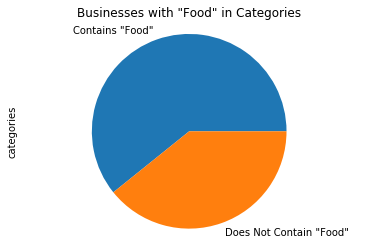

In [6]:
# Task 1 Snippet F - 

<h3 style="color: orange;">Task 2: Cleaning Tampa Health Data</h3>

Our data analysis and exploration of our Tampa Health Data begins by importing the statewide food service inspections for fiscal year 2022-2023 as this is what the Yelp dataset covers up to.  <br><br>
**NOTE** - Due to the large size of the datasets being operated upon, we have not included them in our repository. Please visit https://www2.myfloridalicense.com/hotels-restaurants/public-records/#1506344763000-101d4ee5-7a59 if you wish to run this analysis locally and ensure that the following file is placed in the raw_datasets directory after cloning. You may have to convert it from .xlsx to .csv
+ *fdinspi_2223.csv*

In [7]:
# Task 2 Snippet A - Importing our Tampa Health Data
health_df = pd.read_csv("./raw_datasets/fdinspi_2223.csv")
health_df.columns

FileNotFoundError: File b'./fdinspi_2425.csv' does not exist

As we can see from above, we have a ton of violation codes and other extraneous information that we do not need. To make the dataset more manageable to work with, we select only those columns with information about the violation levels, business name, and address so that we can join this with our review information.

In [ ]:
# Task 2 Snippet B - Selecting our useful features and filtering by city
tampa_health_df = health_df[health_df['LOC_CITY'] == 'TAMPA']
tampa_health_selected_df = tampa_health_df[['DBA_NAME', 'LOC_ADDRESS', 'HIGH_VIOL', 'INTERMED_VIOL', 'BASIC_VIOL']]

In [ ]:
tampa_health_selected_df.head()

<h2 style="color: lightskyblue;">III. Integrating and Joining Data</h2>

To clean our data sets and prepare them for joining so that we may build out our classification models, we pursue 2 tasks:
1. *Cleaning our Yelp data*  
2. *Cleaning our City health inspection data*

<h3 style="color: orange;">Task 1: EXAMPLE</h3>


In [ ]:
# Task X Snippet A - Example


In [ ]:
# Task X Snippet B -Example


<h3 style="color: orange;">Task 2: EXAMPLE</h3>


<h2 style="color: lightskyblue;">IV. Selecting Relevant Features</h2>

To clean our data sets and prepare them for joining so that we may build out our classification models, we pursue 2 tasks:
1. *Cleaning our Yelp data*  
2. *Cleaning our City health inspection data*

<h3 style="color: orange;">Task 1: EXAMPLE</h3>


In [ ]:
# Task X Snippet A - Example


In [ ]:
# Task X Snippet B - Example


<h3 style="color: orange;">Task 2: EXAMPLE</h3>


In [ ]:
# Task X Snippet A - Example


In [ ]:
# Task X Snippet B - Example


<h2 style="color: lightskyblue;">V. Data Transformation</h2>

To clean our data sets and prepare them for joining so that we may build out our classification models, we pursue 2 tasks:
1. *Cleaning our Yelp data*  
2. *Cleaning our City health inspection data*

<h3 style="color: orange;">Task 1: EXAMPLE</h3>


In [ ]:
# Task X Snippet A - Example


In [ ]:
# Task X Snippet B - Example


<h3 style="color: orange;">Task 2: EXAMPLE</h3>


In [ ]:
# Task X Snippet A - Example


In [ ]:
# Task X Snippet B - Example


<h2 style="color: lightskyblue;">VI. Data Mining</h2>

To clean our data sets and prepare them for joining so that we may build out our classification models, we pursue 2 tasks:
1. *Cleaning our Yelp data*  
2. *Cleaning our City health inspection data*

<h3 style="color: orange;">Task 1: EXAMPLE</h3>


In [ ]:
# Task X Snippet A - Example


In [ ]:
# Task X Snippet B - Example


<h3 style="color: orange;">Task 2: EXAMPLE</h3>


In [ ]:
# Task X Snippet A - Example


In [ ]:
# Task X Snippet B - Example


<h2 style="color: lightskyblue;">VII. Pattern Evaluation and Model Construction</h2>

To clean our data sets and prepare them for joining so that we may build out our classification models, we pursue 2 tasks:
1. *Cleaning our Yelp data*  
2. *Cleaning our City health inspection data*

<h3 style="color: orange;">Task 1: EXAMPLE</h3>


In [ ]:
# Task X Snippet A - Example


In [ ]:
# Task X Snippet B - Example


<h3 style="color: orange;">Task 2: EXAMPLE</h3>


In [ ]:
# Task X Snippet A - Example


In [ ]:
# Task X Snippet B - Example


<h2 style="color: lightskyblue;">VIII. Model Performance and Analysis</h2>

To clean our data sets and prepare them for joining so that we may build out our classification models, we pursue 2 tasks:
1. *Cleaning our Yelp data*  
2. *Cleaning our City health inspection data*

<h3 style="color: orange;">Task 1: EXAMPLE</h3>


In [ ]:
# Task X Snippet A - Example


In [ ]:
# Task X Snippet B - Example


<h3 style="color: orange;">Task 2: EXAMPLE</h3>


In [ ]:
# Task X Snippet A - Example


In [ ]:
# Task X Snippet B - Example
